# 데이터 이해하기
---

In [361]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings

data_path = Path('data')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

C:\Users\jslee\.conda\envs\jupyter\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# 데이터의 전처리
---

## 항목별 기본분석

In [362]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

* data의 UserId 컬럼의 Unique 갯수는 6040, ItemId 컬럼의 Unique 갯수는 3706이다.

## Session Length

In [363]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

* session_length에 UserId 별 영화 시청 횟수를 구하여 넣어준다

In [364]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

* session_length의 중간값은 96.0, 평균은 165.59.... 이다.

In [365]:
session_length.min(), session_length.max()

(20, 2314)

* session_length의 최소값은 20, 최대값은 2314이다.

In [366]:
session_length.quantile(0.999)

1343.181000000005

* session_length의 99.9%는 1343.181... 이하이다. 2314라는 수치는 이상하다.(이상치일 확률이 크다)

In [367]:
long_session = session_length[session_length==2314].index[0]
print(long_session)
data[data['UserId']==long_session].head(50)

4169


,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
696168,4169,3801,5,965333481
696250,4169,3841,2,965333481
697903,4169,3761,3,965333481
697954,4169,3788,3,965333481
695653,4169,3794,4,965333519


* session_length가 2314인 인데스로 data 데이터프레임에서 확인결과 Time 컬럼을 보면 동시간대 여러번 rating을 매긴걸 확인 할 수 있다.(예를 들어 평점 테러..?)

In [368]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

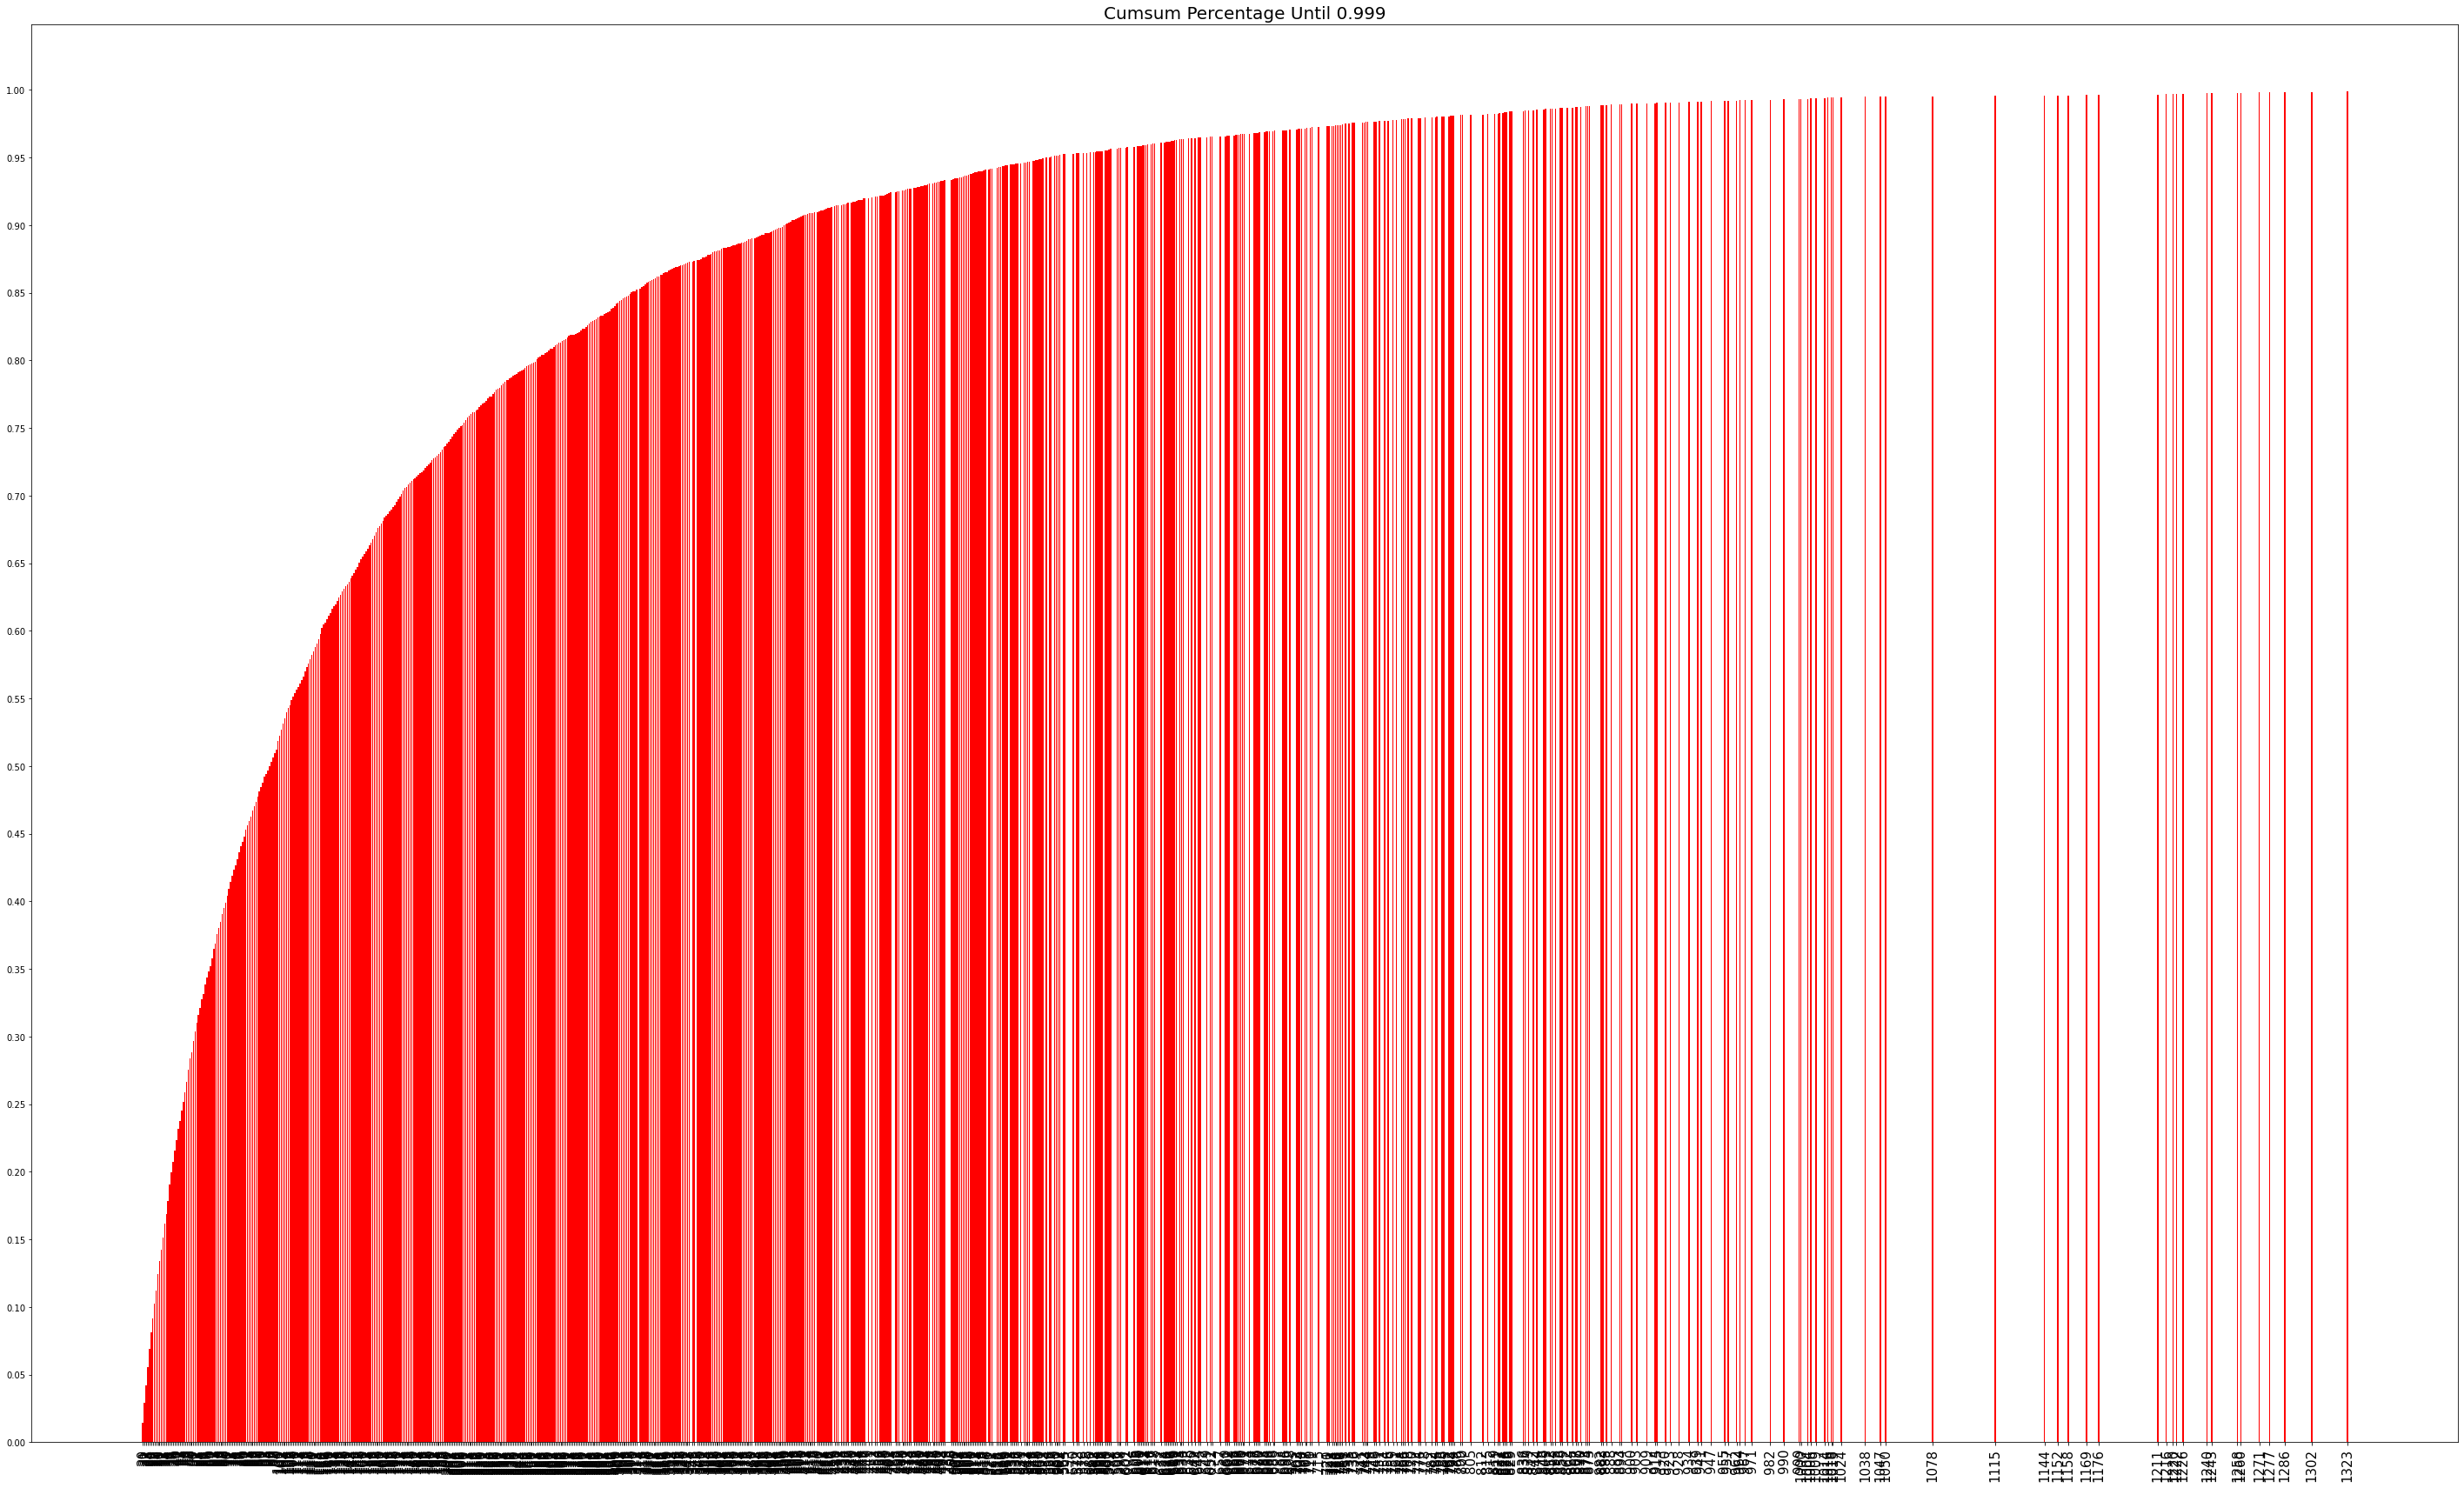

In [369]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 30))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index, rotation=90, fontsize=15)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [370]:
session_length.quantile(0.95)

556.0

In [371]:
drop_index = session_length[session_length>556].index
data.drop(index=drop_index, inplace=True)

* 95 프로 이상은 이상치로 판단하고 데이터에서 삭제해 준다.

## session time

In [372]:
from datetime import datetime

def timestamp_convert(series_time):
    temp = series_time.copy()
    for i, v in enumerate(series_time):
        temp.iloc[i] = datetime.fromtimestamp(v)
    return temp

data['Time'] = timestamp_convert(data['Time'])
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43


* Time 컬럼을 POSIX 타임스탬프에서 tz의 현지 시간으로 변환한다.

In [373]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest) 

2000-04-26 08:05:32
2003-03-01 02:49:50


In [374]:
year_ago = latest - dt.timedelta(365*2)     # 최종 날짜로부터 365일*2(2년) 이전 날짜를 구한다.  
data = data[data['Time'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data.head(50)

,UserId,ItemId,Rating,Time
2327,19,318,4,2001-07-08 10:43:18
2492,19,1234,5,2001-07-08 10:43:56
2503,20,1694,3,2001-12-30 08:37:51
2512,20,1468,3,2001-12-30 08:37:51
2513,20,3717,2,2001-12-30 08:37:51
2517,20,2858,4,2001-12-30 08:37:51
2504,20,2641,4,2001-12-30 08:38:35
2510,20,1375,3,2001-12-30 08:38:35
2520,20,3753,5,2001-12-30 08:38:36
2511,20,1527,5,2001-12-30 08:39:41


* 최종 날짜로부터 1년 전까지의 데이터만 모은다

## Session ID

In [375]:
data = data.copy()

# Time 각 행 중 이전행과 비교를 통해 Time 의 차이를 구한다
data['Time_diff'] = (data['Time'] - data['Time'].shift(1))
data['Time_diff'] = data['Time_diff'].fillna("0:0:0") # 첫번째 인덱스는 비교대상이 없으므로 0으로 초기화 해준다.

timediff_idx = data.index[data['Time_diff']>'0:30:0'] # 차이가 30분 이상 나는 행들의 인덱스 추출
UserId_idx = data.index[data['UserId'] != data['UserId'].shift(1)] # 이전 행과 UserId가 달라진 인덱스 추출

total_idx = list(timediff_idx.append(UserId_idx).unique()) # 위에서 구한 두인덱스를 합한 후 유니크한 인덱스만 추출
all_idx = list(data.index) # data의 전체 인덱스

value = 0
dic = {}
data['SessionId'] = 0

# 전체 인덱 스 중 total_idx가 포함되어 있으면 +1 후 그 값을 대입하고 아니면 이전값 그대로 대입한다.
for i in all_idx:
    if i in total_idx:
        data.loc[i, 'SessionId'] = value
        value += 1
    else:
        data.loc[i, 'SessionId'] = value

data.head(20)

,UserId,ItemId,Rating,Time,Time_diff,SessionId
2327,19,318,4,2001-07-08 10:43:18,0 days 00:00:00,0
2492,19,1234,5,2001-07-08 10:43:56,0 days 00:00:38,1
2503,20,1694,3,2001-12-30 08:37:51,174 days 21:53:55,1
2512,20,1468,3,2001-12-30 08:37:51,0 days 00:00:00,2
2513,20,3717,2,2001-12-30 08:37:51,0 days 00:00:00,2
2517,20,2858,4,2001-12-30 08:37:51,0 days 00:00:00,2
2504,20,2641,4,2001-12-30 08:38:35,0 days 00:00:44,2
2510,20,1375,3,2001-12-30 08:38:35,0 days 00:00:00,2
2520,20,3753,5,2001-12-30 08:38:36,0 days 00:00:01,2
2511,20,1527,5,2001-12-30 08:39:41,0 days 00:01:05,2


* Session 아이디를 값을 더해주기 위한 조건은
    * Time이 이전 행과 30분 이상 차이가 나거나
    * UserId가 달라졌거나 이다.
    

## Data Cleansing

In [376]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [377]:
data = cleanse_recursive(data, shortest=3, least_click=20)
data

,UserId,ItemId,Rating,Time,Time_diff,SessionId
2513,20,3717,2,2001-12-30 08:37:51,0 days 00:00:00,2
2517,20,2858,4,2001-12-30 08:37:51,0 days 00:00:00,2
2504,20,2641,4,2001-12-30 08:38:35,0 days 00:00:44,2
2510,20,1375,3,2001-12-30 08:38:35,0 days 00:00:00,2
2520,20,3753,5,2001-12-30 08:38:36,0 days 00:00:01,2
...,...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29,0 days 00:00:31,8863
999988,6040,1921,4,2001-08-10 23:41:04,0 days 00:00:35,8863
1000172,6040,1784,3,2001-08-10 23:41:04,0 days 00:00:00,8863
1000167,6040,161,3,2001-08-10 23:41:26,0 days 00:00:22,8863


In [378]:
# 필요 없어진 Time_diff 컬럼을 삭제해준다.
data.drop('Time_diff', axis=1, inplace=True)
data

,UserId,ItemId,Rating,Time,SessionId
2513,20,3717,2,2001-12-30 08:37:51,2
2517,20,2858,4,2001-12-30 08:37:51,2
2504,20,2641,4,2001-12-30 08:38:35,2
2510,20,1375,3,2001-12-30 08:38:35,2
2520,20,3753,5,2001-12-30 08:38:36,2
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29,8863
999988,6040,1921,4,2001-08-10 23:41:04,8863
1000172,6040,1784,3,2001-08-10 23:41:04,8863
1000167,6040,161,3,2001-08-10 23:41:26,8863


## Train/Valid/Test split

In [379]:
data['Time'].max(), data['Time'].min() 

(datetime.datetime(2003, 3, 1, 2, 49, 8),
 datetime.datetime(2001, 3, 1, 4, 7, 26))

In [380]:
test_time = data['Time'].max() - dt.timedelta(60)
test_time

datetime.datetime(2002, 12, 31, 2, 49, 8)

In [381]:
valid_time = test_time - dt.timedelta(120)
valid_time

datetime.datetime(2002, 9, 2, 2, 49, 8)

* Train/Valid/Test 데이터프레임을 만들 때 사용할 기준을 만들어준다.

In [382]:
train_df = data[data['Time'] <= valid_time]
train_df.tail()

,UserId,ItemId,Rating,Time,SessionId
1000019,6040,2917,4,2001-08-10 23:40:29,8863
999988,6040,1921,4,2001-08-10 23:41:04,8863
1000172,6040,1784,3,2001-08-10 23:41:04,8863
1000167,6040,161,3,2001-08-10 23:41:26,8863
1000042,6040,1221,4,2001-08-20 22:44:15,8863


In [383]:
test_df = data[data['Time'] > test_time]
test_df

,UserId,ItemId,Rating,Time,SessionId
8704,59,2997,4,2003-01-08 03:02:48,13
8721,59,2147,2,2003-01-08 03:03:59,14
8781,59,2369,4,2003-01-08 03:04:24,14
8797,59,3408,4,2003-01-08 03:04:52,14
8808,59,2712,3,2003-01-08 03:04:52,14
...,...,...,...,...,...
984731,5950,3948,4,2003-02-28 03:13:57,8803
984682,5950,3578,4,2003-02-28 03:14:30,8803
984475,5950,3793,3,2003-02-28 03:15:10,8803
984660,5950,3555,2,2003-02-28 03:15:37,8803


In [384]:
temp_df = data[data['Time'] <= test_time]
val_df = temp_df[temp_df['Time'] > valid_time]
val_df

,UserId,ItemId,Rating,Time,SessionId
5184,36,2694,3,2002-12-22 17:08:14,12
5364,36,3786,4,2002-12-22 17:08:41,12
5262,36,2369,4,2002-12-22 17:09:24,12
5069,36,2713,1,2002-12-22 17:11:02,12
5280,36,3174,4,2002-12-22 17:11:25,12
...,...,...,...,...,...
959025,5787,441,4,2002-10-06 04:58:05,8711
958819,5787,3852,3,2002-10-06 04:58:29,8711
958987,5787,1297,3,2002-10-06 04:58:29,8711
959090,5787,2706,4,2002-10-06 04:58:29,8711


* data에 들어있는 값은 전처리를 통해 총 2년치의 데이터이다.    
  이 데이터를 train/valid/test로 나눈다.
    * train : 18개월(30*18)
    * valid : 4개월(30*4)
    * test : 2개월(30*2)

In [385]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [386]:
stats_info(train_df, 'train')
stats_info(val_df, 'valid')
stats_info(test_df, 'test')

* train Set Stats Info
	 Events: 39658
	 Sessions: 2432
	 Items: 1075
	 First Time : 2001-03-01 04:07:26
	 Last Time : 2002-09-01 09:14:13

* valid Set Stats Info
	 Events: 3406
	 Sessions: 287
	 Items: 981
	 First Time : 2002-09-02 04:44:55
	 Last Time : 2002-12-31 01:47:52

* test Set Stats Info
	 Events: 2167
	 Sessions: 157
	 Items: 892
	 First Time : 2002-12-31 04:40:24
	 Last Time : 2003-03-01 02:49:08



In [387]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train_df['ItemId'].unique())}
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train_df = indexing(train_df, id2idx)
val_df = indexing(val_df, id2idx)
test_df = indexing(test_df, id2idx)

C:\Users\jslee\AppData\Local\Temp/ipykernel_2116/2406853728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.


In [388]:
data_path = Path('data')
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train_df.to_pickle(save_path / 'train.pkl')
val_df.to_pickle(save_path / 'valid.pkl')
test_df.to_pickle(save_path / 'test.pkl')

* Train/Valid/Test Dataset을 만들어 줬다.

# 미니 배치의 구성
---

## SessionDataset

In [389]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [390]:
tr_dataset = SessionDataset(train_df)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
2513,20,3717,2,2001-12-30 08:37:51,2,0
2517,20,2858,4,2001-12-30 08:37:51,2,1
2504,20,2641,4,2001-12-30 08:38:35,2,2
2510,20,1375,3,2001-12-30 08:38:35,2,3
2520,20,3753,5,2001-12-30 08:38:36,2,4
2511,20,1527,5,2001-12-30 08:39:41,2,5
2523,20,1240,4,2001-12-30 08:39:41,2,6
2509,20,1371,4,2001-12-30 08:40:27,2,7
2671,22,1884,4,2001-05-30 00:10:55,2,8
2776,22,2376,3,2001-05-30 00:12:20,3,9


In [391]:
tr_dataset.click_offsets

array([    0,     9,    19, ..., 39633, 39639, 39658])

In [392]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2429, 2430, 2431])

## SessionDataLoader

In [393]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [394]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
2513,20,3717,2,2001-12-30 08:37:51,2,0
2517,20,2858,4,2001-12-30 08:37:51,2,1
2504,20,2641,4,2001-12-30 08:38:35,2,2
2510,20,1375,3,2001-12-30 08:38:35,2,3
2520,20,3753,5,2001-12-30 08:38:36,2,4
2511,20,1527,5,2001-12-30 08:39:41,2,5
2523,20,1240,4,2001-12-30 08:39:41,2,6
2509,20,1371,4,2001-12-30 08:40:27,2,7
2671,22,1884,4,2001-05-30 00:10:55,2,8
2776,22,2376,3,2001-05-30 00:12:20,3,9


In [395]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
2513,20,3717,2,2001-12-30 08:37:51,2,0
2517,20,2858,4,2001-12-30 08:37:51,2,1
2504,20,2641,4,2001-12-30 08:38:35,2,2
2510,20,1375,3,2001-12-30 08:38:35,2,3
2520,20,3753,5,2001-12-30 08:38:36,2,4
2511,20,1527,5,2001-12-30 08:39:41,2,5
2523,20,1240,4,2001-12-30 08:39:41,2,6
2509,20,1371,4,2001-12-30 08:40:27,2,7
2671,22,1884,4,2001-05-30 00:10:55,2,8
2776,22,2376,3,2001-05-30 00:12:20,3,9


In [396]:
iter_ex = iter(tr_data_loader)

In [397]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  9 19 40]
Label Item Idx are :       [ 1 10 20 41]
Previous Masked Input Idx are []


# 모델 구성
---

## Evaluation Metric

In [398]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

In [399]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [400]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [401]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train_df, val_df, test_df, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [402]:
model = create_model(args)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 1075)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      169050    
_________________________________________________________________
dropout_2 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 1075)                54825     
Total params: 223,875
Trainable params: 223,875
Non-trainable params: 0
_________________________________________________________________


# 모델 학습
---

In [403]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [404]:
train_model(model, args)

Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  6.05it/s]


	 - Recall@20 epoch 1: 0.045496
	 - MRR@20    epoch 1: 0.009436



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  6.05it/s]


	 - Recall@20 epoch 2: 0.072610
	 - MRR@20    epoch 2: 0.014484



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:16<00:06,  4.21it/s]


	 - Recall@20 epoch 3: 0.085938
	 - MRR@20    epoch 3: 0.020980



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:19<00:08,  3.51it/s]


	 - Recall@20 epoch 4: 0.110294
	 - MRR@20    epoch 4: 0.026313



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:13<00:05,  4.99it/s]


	 - Recall@20 epoch 5: 0.137868
	 - MRR@20    epoch 5: 0.036046



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:12<00:05,  5.48it/s]


	 - Recall@20 epoch 6: 0.145221
	 - MRR@20    epoch 6: 0.039359



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  6.03it/s]


	 - Recall@20 epoch 7: 0.153493
	 - MRR@20    epoch 7: 0.042951



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  5.81it/s]


	 - Recall@20 epoch 8: 0.157169
	 - MRR@20    epoch 8: 0.044250



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  5.98it/s]


	 - Recall@20 epoch 9: 0.161305
	 - MRR@20    epoch 9: 0.046116



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:16<00:06,  4.18it/s]

	 - Recall@20 epoch 10: 0.164982
	 - MRR@20    epoch 10: 0.046472



# 모델 테스트
---

## 조건 1

* batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20
* cleanse_recursive(data, shortest=3, least_click=20)

In [405]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test_df)

Evaluation:  52%|████████████████████████████████████▏                                 | 32/62 [00:06<00:06,  4.66it/s]

	 - Recall@20: 0.162109
	 - MRR@20: 0.053991



## 조건 2

* batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20
* cleanse_recursive(data, shortest=3, least_click=20)
* epochs 횟수만 20으로 증가시켜 보았다.

In [409]:
args = Args(train_df, val_df, test_df, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 1, 1075)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      169050    
_________________________________________________________________
dropout_4 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (32, 1075)                54825     
Total params: 223,875
Trainable params: 223,875
Non-trainable params: 0
_________________________________________________________________


In [410]:
train_model(model, args)

Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:05,  5.70it/s]


	 - Recall@20 epoch 1: 0.044577
	 - MRR@20    epoch 1: 0.009734



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  5.97it/s]


	 - Recall@20 epoch 2: 0.061581
	 - MRR@20    epoch 2: 0.012626



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:10<00:04,  6.24it/s]


	 - Recall@20 epoch 3: 0.082261
	 - MRR@20    epoch 3: 0.019761



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:10<00:04,  6.29it/s]


	 - Recall@20 epoch 4: 0.100184
	 - MRR@20    epoch 4: 0.024790



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  5.91it/s]


	 - Recall@20 epoch 5: 0.118107
	 - MRR@20    epoch 5: 0.031031



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:10<00:04,  6.40it/s]


	 - Recall@20 epoch 6: 0.130515
	 - MRR@20    epoch 6: 0.034113



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:10<00:04,  6.49it/s]


	 - Recall@20 epoch 7: 0.145221
	 - MRR@20    epoch 7: 0.039138



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:10<00:04,  6.51it/s]


	 - Recall@20 epoch 8: 0.152574
	 - MRR@20    epoch 8: 0.040707



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:10<00:04,  6.53it/s]


	 - Recall@20 epoch 9: 0.156250
	 - MRR@20    epoch 9: 0.042889



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:10<00:04,  6.49it/s]


	 - Recall@20 epoch 10: 0.155790
	 - MRR@20    epoch 10: 0.044291



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  5.95it/s]


	 - Recall@20 epoch 11: 0.153493
	 - MRR@20    epoch 11: 0.043427



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  6.03it/s]


	 - Recall@20 epoch 12: 0.154871
	 - MRR@20    epoch 12: 0.043965



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  6.16it/s]


	 - Recall@20 epoch 13: 0.152574
	 - MRR@20    epoch 13: 0.043409



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  5.89it/s]


	 - Recall@20 epoch 14: 0.151195
	 - MRR@20    epoch 14: 0.042942



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:10<00:04,  6.40it/s]


	 - Recall@20 epoch 15: 0.146599
	 - MRR@20    epoch 15: 0.042148



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:12<00:05,  5.66it/s]


	 - Recall@20 epoch 16: 0.144301
	 - MRR@20    epoch 16: 0.041348



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:05,  5.76it/s]


	 - Recall@20 epoch 17: 0.142923
	 - MRR@20    epoch 17: 0.041135



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  6.11it/s]


	 - Recall@20 epoch 18: 0.142463
	 - MRR@20    epoch 18: 0.039906



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:10<00:04,  6.25it/s]


	 - Recall@20 epoch 19: 0.141085
	 - MRR@20    epoch 19: 0.040148



Evaluation:  70%|█████████████████████████████████████████████████                     | 68/97 [00:11<00:04,  6.14it/s]

	 - Recall@20 epoch 20: 0.140625
	 - MRR@20    epoch 20: 0.039842



In [412]:
test_model(model, args, test_df)

Evaluation:  52%|████████████████████████████████████▏                                 | 32/62 [00:04<00:04,  6.52it/s]

	 - Recall@20: 0.163086
	 - MRR@20: 0.056542



* 조건 1에서 epoch 횟수만 늘렸을 때는 Recall과 MMR에 별 차이가 없다.

## 조건 3

batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20   
cleanse_recursive(data, shortest=3, least_click=20)   
epochs 횟수를 10으로 원복시키고 batch_size를 16으로 변경해보았다.   

In [413]:
args = Args(train_df, val_df, test_df, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(16, 1, 1075)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      169050    
_________________________________________________________________
dropout_5 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_5 (Dense)              (16, 1075)                54825     
Total params: 223,875
Trainable params: 223,875
Non-trainable params: 0
_________________________________________________________________


In [414]:
train_model(model, args)

Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:19<00:03,  8.50it/s]


	 - Recall@20 epoch 1: 0.053627
	 - MRR@20    epoch 1: 0.013465



Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:17<00:03,  9.12it/s]


	 - Recall@20 epoch 2: 0.079861
	 - MRR@20    epoch 2: 0.018597



Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:17<00:03,  9.04it/s]


	 - Recall@20 epoch 3: 0.105710
	 - MRR@20    epoch 3: 0.027966



Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:18<00:03,  8.96it/s]


	 - Recall@20 epoch 4: 0.128086
	 - MRR@20    epoch 4: 0.033910



Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:18<00:03,  8.82it/s]


	 - Recall@20 epoch 5: 0.149691
	 - MRR@20    epoch 5: 0.037773



Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:18<00:03,  8.97it/s]


	 - Recall@20 epoch 6: 0.151620
	 - MRR@20    epoch 6: 0.041152



Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:18<00:03,  8.53it/s]


	 - Recall@20 epoch 7: 0.151620
	 - MRR@20    epoch 7: 0.041878



Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:17<00:03,  9.00it/s]


	 - Recall@20 epoch 8: 0.153164
	 - MRR@20    epoch 8: 0.042332



Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:18<00:03,  8.73it/s]


	 - Recall@20 epoch 9: 0.148148
	 - MRR@20    epoch 9: 0.041992



Evaluation:  84%|████████████████████████████████████████████████████████▊           | 162/194 [00:17<00:03,  9.24it/s]

	 - Recall@20 epoch 10: 0.145448
	 - MRR@20    epoch 10: 0.041534



In [415]:
test_model(model, args, test_df)

Evaluation:  68%|██████████████████████████████████████████████▉                      | 85/125 [00:09<00:04,  8.74it/s]

	 - Recall@20: 0.177206
	 - MRR@20: 0.055700



* batch size 32->16 하였을때 결과치가 좋아졌다. 더 줄여보자.

## 조건 4

batch_size=8, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20
cleanse_recursive(data, shortest=3, least_click=20)
epochs 횟수를 10으로 원복시키고 batch_size를 16으로 변경해보았다.

In [416]:
args = Args(train_df, val_df, test_df, batch_size=8, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(8, 1, 1075)]            0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        169050    
_________________________________________________________________
dropout_6 (Dropout)          (8, 50)                   0         
_________________________________________________________________
dense_6 (Dense)              (8, 1075)                 54825     
Total params: 223,875
Trainable params: 223,875
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model, args)

Evaluation:  93%|██████████████████████████████████████████████████████████████▉     | 360/389 [00:29<00:02, 12.33it/s]


	 - Recall@20 epoch 1: 0.062153
	 - MRR@20    epoch 1: 0.012038



Evaluation:  93%|██████████████████████████████████████████████████████████████▉     | 360/389 [00:29<00:02, 12.07it/s]


	 - Recall@20 epoch 2: 0.097917
	 - MRR@20    epoch 2: 0.022269



Evaluation:  93%|██████████████████████████████████████████████████████████████▉     | 360/389 [00:28<00:02, 12.72it/s]


	 - Recall@20 epoch 3: 0.125694
	 - MRR@20    epoch 3: 0.030269



Evaluation:  93%|██████████████████████████████████████████████████████████████▉     | 360/389 [00:28<00:02, 12.86it/s]


	 - Recall@20 epoch 4: 0.139236
	 - MRR@20    epoch 4: 0.035219



Evaluation:  93%|██████████████████████████████████████████████████████████████▉     | 360/389 [00:30<00:02, 11.71it/s]


	 - Recall@20 epoch 5: 0.141667
	 - MRR@20    epoch 5: 0.038866



Train:  72%|███████████████████████████▌          | 3372/4653 [00:41<00:15, 83.81it/s, accuracy=0.125, train_loss=5.38]

In [ ]:
test_model(model, args, test_df)

# 회고

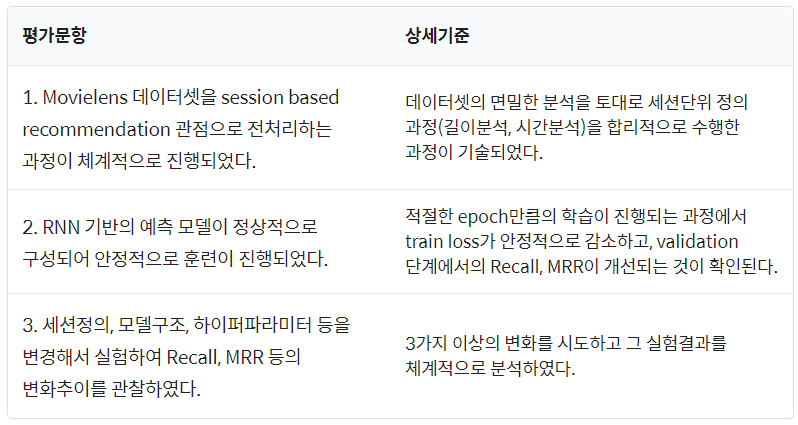

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

* 조건 1   
    * batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20   
        - Recall: 0.162109
        - MRR: 0.053991

* 조건 2   
    * batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20    
        -  Recall: 0.163086
        - MRR: 0.056542

* 조건 3   
    * batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20   
        - Recall@20: 0.177206
        - MRR@20: 0.055700
* 조건 3   
    * batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20   
        - Recall@20: 0.177206
        - MRR@20: 0.055700
* 조건 3   
    * batch_size=8, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20   
        - Recall@20: 0.177206
        - MRR@20: 0.055700
        
이번 프로젝트에서 어려웠던점은 SessionId 컬럼을 만들어주는게 어려웠다. 어떤 기준으로 SessionId를 만들어줄 지 고민을 많이 하였다. 또한 Index Error가 자주 발생하였지만 batch size 조원들이 알려줘서 금방 조치할 수 있었다.   
프로젝트를 진행하면서 알아낸것은 추천 알고리즘에 대한 큰 구도를 이해할 수 있었지만 소스량이 많아 전부 이해하지는 못하였다.   
루브릭을 맞추기위해서는 Recall과 MRR을 높이기 위해 여러 조건으로 학습 및 테스트를 진행하였고, SessionId 컬럼을 만들어 주기 위해 노력하였다.   
자기 다짐은 시각화 다루는 것에 더 능숙해저야 할 것 같다. 시각화를 좀 더 잘 다뤘다면, 세부 내용이나 학습 결과등을 좀 더 쉽게 파악할 수 있었을 거 같은데 아직 미숙하여 시각화를 많이 다루지 못하여 아쉽다.
또한, 다른 조원들과 비교하였을때 결과치가 기대에 못 미쳐 여러 시도들(Session 여러 조건으로 나누기, 모델 구조 변경, 데이터 전처리 등등...)을 해볼 수 있었을 거 같았은데 시간에 쫓겨 많은 시도를 못해봐서 아쉽다.